In [3]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
df = pd.read_csv("../data/Twitter_volume_AMZN.csv")

In [7]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


In [8]:
#Understanding Data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15831 entries, 0 to 15830
Data columns (total 2 columns):
timestamp    15831 non-null object
value        15831 non-null int64
dtypes: int64(1), object(1)
memory usage: 247.4+ KB
None


In [9]:
# check the timestamp format and frequency
print(df['timestamp'].head(10))

0    2015-02-26 21:42:53
1    2015-02-26 21:47:53
2    2015-02-26 21:52:53
3    2015-02-26 21:57:53
4    2015-02-26 22:02:53
5    2015-02-26 22:07:53
6    2015-02-26 22:12:53
7    2015-02-26 22:17:53
8    2015-02-26 22:22:53
9    2015-02-26 22:27:53
Name: timestamp, dtype: object


In [10]:
# check the Twitter-Amazon mean volume
print(df['value'].mean())

53.29846503695281


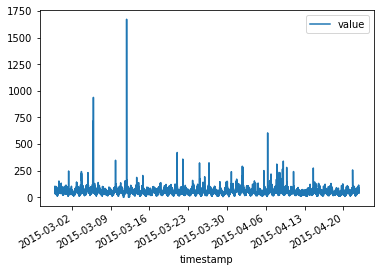

In [29]:
#Reference: https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# plot the data
df.plot(x='timestamp', y='value')

In [12]:
#Feature Engineering

# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [13]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [17]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

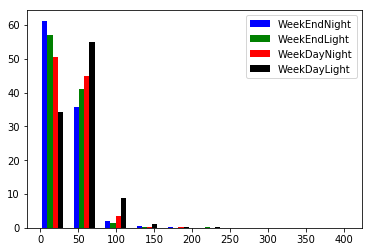

In [18]:
# creation of 4 distinct categories(week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [19]:
#Twitter Volume is more stable during the Weekday Night

In [21]:
#Using Isolation Forest - Used for collective anomalies (unordered).
#Simple, works well with different data repartition and efficient with high dimention data.

In [22]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0    15671
1      160
Name: anomaly25, dtype: int64


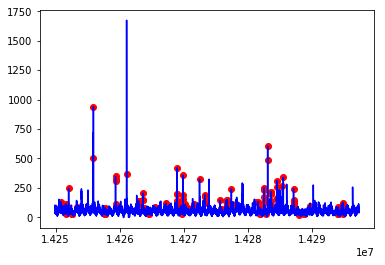

In [23]:
# visualisation of anomaly throughout time
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

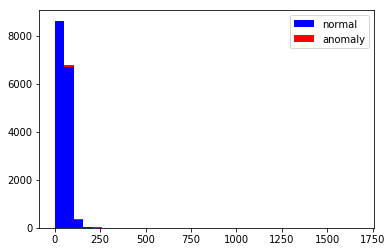

In [24]:
# visualisation of anomaly with volume repartition
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

In [25]:
#One Class SVM - Use for collective anomalies (unordered)
#Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [26]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)

# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    15663
1      168
Name: anomaly26, dtype: int64


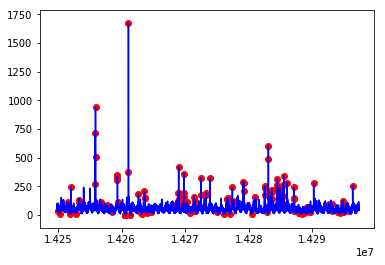

In [27]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

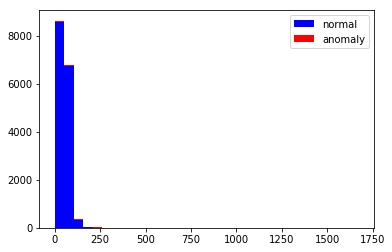

In [28]:
# visualisation of anomaly with volume repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [30]:
#Both of the result looks almost similar. 
#It found some anomalies in average values which might or might not be relevant.